# Visualize the discriminability of AlexNet for textures

## pre-process textures

In [33]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sphere.models.nets.convnet import PreTrainedConvNet
import pandas as pd
from PIL import Image
from glob import glob
import sys
from sklearn.manifold import TSNE
import seaborn as sns 

%matplotlib inline
%load_ext rmagic

# where the textures were downloaded to
path = '/Users/dganguli/Desktop/textureSamples/'

def load_texture_samples(path):
    """
        returns: Pandas DataFrame of | path | sample | category
    """
    files = jpgs = glob(path + '/*mat')
    file_names = [fn.split('/')[-1] for fn in files]
    parts = [fn.split('-') for fn in files]
    labels = [p[2] for p in parts]
    sample_nums = [int(p[3].split('.')[0][3:]) for p in parts]
    df = pd.DataFrame({'path':files, 'label':labels, 'sample':sample_nums})
    label_map = df.label.drop_duplicates().reset_index()
    label_map['index'] = label_map.index
    label_map.rename(columns={'index':'category'}, inplace=True)
    df = pd.merge(df, label_map, on='label')
    del df['label']
    df = df.sort(['sample', 'category']).reset_index(drop=True)
    return df

def convert_mat_to_png(df):
    mat2png = dict()

    for ind, fn in enumerate(df.path):
        if ind % 100 == 0:
            print ind
        try:
            img = loadmat(fn)['res']
            png_path = fn.replace('.mat', '.png')
            plt.imsave(png_path,img)
            Image.open(png_path).convert('L').save(png_path)
            mat2png[fn] = png_path
        except:
            print 'Could not load/convert: {} to a grayscale png'.format(fn)
            print 'Unexpected Error: {}'.format(sys.exc_info()[0])
    
    df['png_path'] = df.path.apply(lambda x : mat2png.get(x,None))
    return df

def tsne_layer(net, layer, plot=False):
    hidden = get_center_activity(net.hidden_layer_outputs[layer])
    tsne = TSNE(perplexity=30, learning_rate=500, verbose=30)
    embedded = tsne.fit_transform(hidden.astype(float))
    
    if plot:
        x, y = embedded[:, 0], embedded[:, 1]
        plt.figure()
        plt.scatter(x, y, lw=0.01, s=10.0, alpha=0.15, c='k', zorder=1e9)
        plt.scatter(x, y, lw=0.01, s=10.0, alpha=0.15, c='k', zorder=1e9)
    
    return x, y

def get_center_activity(tensor):
    
    if len(tensor.shape) == 4: # convolutional layer
        center_x = tensor.shape[2]/2
        center_y = tensor.shape[3]/2
        res = tensor[:,:,center_x, center_y]
    else: # fully connected layer
        res = tensor
    
    return res
    

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


In [5]:
df = convert_mat_to_png(load_texture_samples(path)) 
df.head()

0
100
200
300
400
500
600
700
800
Could not load/convert: /Users/dganguli/Desktop/textureSamples/tex-320x320-im152-smp55.mat to a grayscale png
Unexpected Error: <type 'exceptions.KeyError'>
900
1000
1100
1200
1300
1400


,path,sample,category,png_path
0,/Users/dganguli/Desktop/textureSamples/tex-320...,1,0,/Users/dganguli/Desktop/textureSamples/tex-320...
1,/Users/dganguli/Desktop/textureSamples/tex-320...,1,1,/Users/dganguli/Desktop/textureSamples/tex-320...
2,/Users/dganguli/Desktop/textureSamples/tex-320...,1,2,/Users/dganguli/Desktop/textureSamples/tex-320...
3,/Users/dganguli/Desktop/textureSamples/tex-320...,1,3,/Users/dganguli/Desktop/textureSamples/tex-320...
4,/Users/dganguli/Desktop/textureSamples/tex-320...,1,4,/Users/dganguli/Desktop/textureSamples/tex-320...


## pass textures through alex net to get out hidden layer activations

In [8]:
hidden_activation_layers = ['conv1', 'pool1', 'norm1', 
                            'conv2', 'pool2', 'norm2',
                            'conv3', 'conv4', 'conv5',
                            'pool5',
                            'fc6', 'fc7', 'fc8']

anet = PreTrainedConvNet(test_df = df.dropna(),
                        path_col = 'png_path',
                        caffe_root='/Users/dganguli/src/caffe/',
                        hidden_activation_layers = hidden_activation_layers,
                        trained_model_name = 'AlexNet'
                        )
anet.predict()
anet.summarize()

Pre-processing inputs...
... Done.
Taking forward pass...
... Done
Network Architecture: 
[('data', (10, 3, 227, 227)), ('conv1', (10, 96, 55, 55)), ('pool1', (10, 96, 27, 27)), ('norm1', (10, 96, 27, 27)), ('conv2', (10, 256, 27, 27)), ('pool2', (10, 256, 13, 13)), ('norm2', (10, 256, 13, 13)), ('conv3', (10, 384, 13, 13)), ('conv4', (10, 384, 13, 13)), ('conv5', (10, 256, 13, 13)), ('pool5', (10, 256, 6, 6)), ('fc6', (10, 4096)), ('fc7', (10, 4096)), ('fc8', (10, 1000)), ('prob', (10, 1000))]

Hidden layer output dimensions: {'pool2': (1499, 256, 13, 13), 'fc6': (1499, 4096), 'fc7': (1499, 4096), 'fc8': (1499, 1000), 'conv3': (1499, 384, 13, 13), 'conv2': (1499, 256, 27, 27), 'conv1': (1499, 96, 55, 55), 'conv5': (1499, 256, 13, 13), 'conv4': (1499, 384, 13, 13), 'norm2': (1499, 256, 13, 13), 'pool1': (1499, 96, 27, 27), 'norm1': (1499, 96, 27, 27), 'pool5': (1499, 256, 6, 6)}

Softmax output dimensions: (1499, 1000)


## classify one texture from each of the 15 categories. labels are from the 1000 category ImageNet classification task

,label,score
858,"tile, roof",0.429485
490,"chain, mail, ring, mail, mail, chain, armor, c...",0.323329
489,"chainlink, fence",0.100241
488,chain,0.025156
611,"jigsaw, puzzle",0.020193


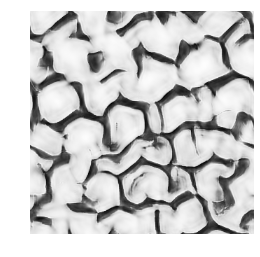

In [9]:
anet.show_prediction(0)

,label,score
562,fountain,0.048125
310,"ant, emmet, pismire",0.041997
795,ski,0.037127
970,alp,0.034809
327,"starfish, sea, star",0.032045


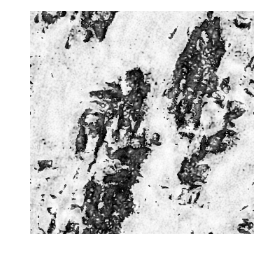

In [10]:
anet.show_prediction(1)

,label,score
310,"ant, emmet, pismire",0.059790
552,"feather, boa, boa",0.042011
746,"puck, hockey, puck",0.030341
970,alp,0.026448
701,"parachute, chute",0.025837


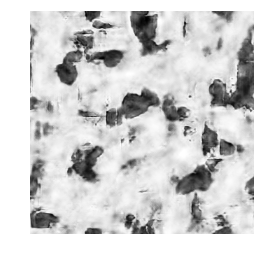

In [11]:
anet.show_prediction(2)

,label,score
611,"jigsaw, puzzle",0.242710
393,"anemone, fish",0.093222
788,"shoe, shop, shoe-shop, shoe, store",0.085789
858,"tile, roof",0.035039
666,mortar,0.031931


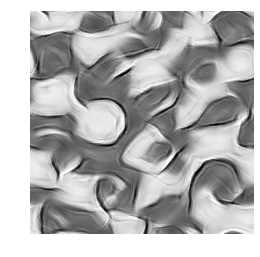

In [12]:
anet.show_prediction(3)

,label,score
739,"potter's, wheel",0.179789
108,"sea, anemone, anemone",0.069789
837,"sunglasses, dark, glasses, shades",0.067387
390,eel,0.039024
910,"wooden, spoon",0.033433


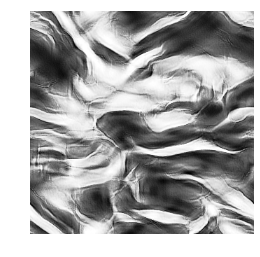

In [13]:
anet.show_prediction(4)

,label,score
108,"sea, anemone, anemone",0.103987
917,"comic, book",0.089420
953,"pineapple, ananas",0.085310
611,"jigsaw, puzzle",0.063057
794,"shower, curtain",0.044401


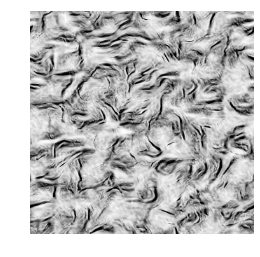

In [14]:
anet.show_prediction(5)

,label,score
490,"chain, mail, ring, mail, mail, chain, armor, c...",0.768678
488,chain,0.069091
677,nail,0.046467
783,screw,0.013674
772,"safety, pin",0.013029


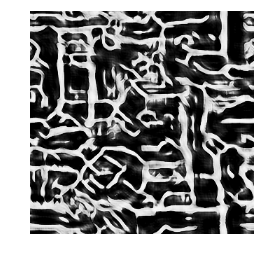

In [15]:
anet.show_prediction(6)

,label,score
108,"sea, anemone, anemone",0.145771
111,"nematode, nematode, worm, roundworm",0.127341
488,chain,0.113978
539,"doormat, welcome, mat",0.088755
109,"brain, coral",0.033092


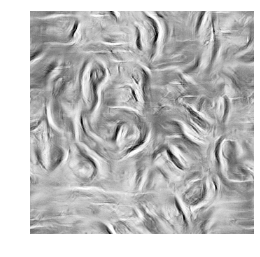

In [16]:
anet.show_prediction(7)

,label,score
108,"sea, anemone, anemone",0.303478
953,"pineapple, ananas",0.210443
946,cardoon,0.073907
616,knot,0.073003
393,"anemone, fish",0.037623


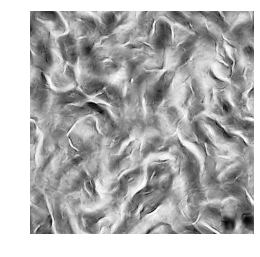

In [17]:
anet.show_prediction(8)

,label,score
489,"chainlink, fence",0.069981
611,"jigsaw, puzzle",0.068716
629,"lipstick, lip, rouge",0.039905
869,"trench, coat",0.037069
508,"computer, keyboard, keypad",0.032360


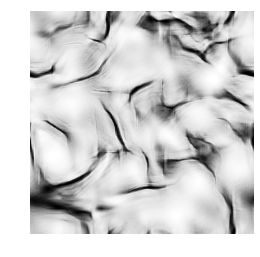

In [18]:
anet.show_prediction(9)

,label,score
991,"coral, fungus",0.153477
998,"ear, spike, capitulum",0.151199
840,"swab, swob, mop",0.089576
490,"chain, mail, ring, mail, mail, chain, armor, c...",0.057483
108,"sea, anemone, anemone",0.054986


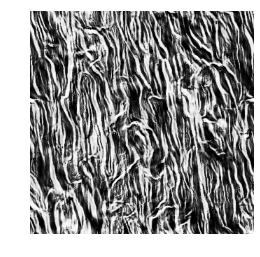

In [19]:
anet.show_prediction(10)

,label,score
490,"chain, mail, ring, mail, mail, chain, armor, c...",0.125377
824,stole,0.119103
794,"shower, curtain",0.081902
533,"dishrag, dishcloth",0.078094
918,"crossword, puzzle, crossword",0.041584


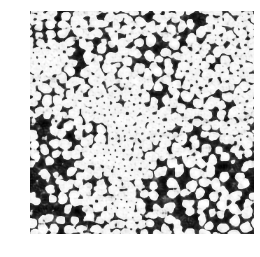

In [20]:
anet.show_prediction(11)

,label,score
599,honeycomb,0.894738
398,abacus,0.024394
490,"chain, mail, ring, mail, mail, chain, armor, c...",0.020861
794,"shower, curtain",0.012189
489,"chainlink, fence",0.007823


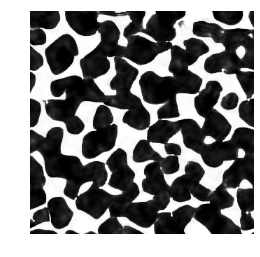

In [21]:
anet.show_prediction(12)

,label,score
917,"comic, book",0.571680
921,"book, jacket, dust, cover, dust, jacket, dust,...",0.039189
825,"stone, wall",0.035521
611,"jigsaw, puzzle",0.023711
652,"military, uniform",0.020091


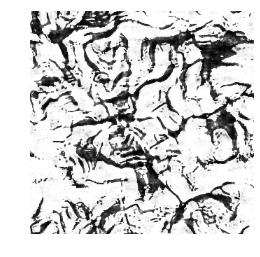

In [22]:
anet.show_prediction(13)

,label,score
108,"sea, anemone, anemone",0.330076
201,"silky, terrier, Sydney, silky",0.220145
340,zebra,0.068720
187,"Yorkshire, terrier",0.048889
200,"Tibetan, terrier, chrysanthemum, dog",0.026461


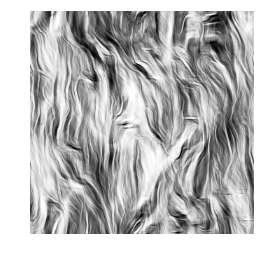

In [23]:
anet.show_prediction(14)

## t-sne all the layers. for convolutional layers pick the center of each neurons receptive field to represent it's activity

In [ ]:
c1x, c1y = tsne_layer(anet, 'conv1')

In [ ]:
p1x, p1y = tsne_layer(anet, 'pool1')

In [ ]:
n1x, n1y = tsne_layer(anet, 'norm1')

In [ ]:
c2x, c2y = tsne_layer(anet, 'conv2')

In [ ]:
p2x, p2y = tsne_layer(anet, 'pool2')

In [ ]:
n2x, n2y = tsne_layer(anet, 'norm2')

In [ ]:
c3x, c3y = tsne_layer(anet, 'conv3')

In [ ]:
c4x, c4y = tsne_layer(anet, 'conv4')

In [ ]:
c5x, c5y = tsne_layer(anet, 'conv5')

In [ ]:
p5x, p5y = tsne_layer(anet, 'pool5')

In [ ]:
fc6x, fc6y = tsne_layer(anet, 'fc6')

In [ ]:
fc7x, fc7y = tsne_layer(anet, 'fc7')

In [ ]:
fc8x, fc8y = tsne_layer(anet, 'fc8')

## munge data for easy plotting in ggplot

In [ ]:
num_layers = 13

cats = list(df.category.values)*num_layers
x = np.concatenate((c1x,p1x,n1x,c2x,p2x,n2x,c3x,c4x,c5x,p5x,fc6x,fc7x,fc8x))
y = np.concatenate((c1y,p1y,n1y,c2y,p2y,n2y,c3y,c4y,c5y,p5y,fc6y,fc7y,fc8y))
layers = reduce(lambda x, y: x+y, [[h]*1499 for h in hidden_activation_layers])

df_tidy = pd.DataFrame({'x': x, 'y':y, 'category':cats, 'layer':layers})
df_tidy.head()

In [ ]:
df_tidy.to_csv('/Users/dganguli/Desktop/deep_metamers_tidy.csv',index=False)

## visualize t-sne for each layer


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



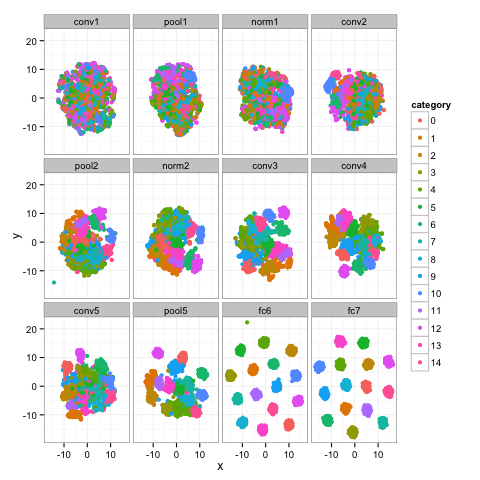

In [24]:
%%R

library(ggplot2)
library(dplyr)
library(tidyr)

df <- read.csv('/Users/dganguli/Desktop/deep_metamers_tidy.csv') %>% as.tbl()
df$category <- as.factor(df$category)

df$layer = factor(df$layer, 
                  levels = c("conv1", "pool1", "norm1", "conv2", "pool2", "norm2", "conv3", "conv4", "conv5", "pool5", "fc6", "fc7", "fc8")
)

df %>% 
  filter(layer != 'fc8') %>% 
  ggplot(aes(x=x,y=y,color=category)) + 
    geom_point() + 
    facet_wrap(~ layer) + theme_bw()

## visualize correlation between mean 'neural' activity between pairs of textures

In [56]:
import numpy as np

text_1 = 4
text_2 = 13
ind_1 = df[df.category==text_1].index
ind_2 = df[df.category==text_2].index

mu_1s = [np.mean(get_center_activity(v)[ind_1,:],axis=0) for k, v in anet.hidden_layer_outputs.iteritems()]
mu_2s = [np.mean(get_center_activity(v)[ind_2,:],axis=0) for k, v in anet.hidden_layer_outputs.iteritems()]
num_units = [get_center_activity(v).shape[1] for k, v in anet.hidden_layer_outputs.iteritems()]
layers = [k for k, v in anet.hidden_layer_outputs.iteritems()]

In [57]:
mu_1 = np.concatenate(mu_1s)
mu_2 = np.concatenate(mu_2s)
layer = reduce(lambda x, y: x+y, [[k]*v for k, v in zip(layers, num_units)])

In [71]:
df_mu = pd.DataFrame({'mu_1':mu_1, 'mu_2':mu_2, 'layer': layer})
df_mu.to_csv('/Users/dganguli/Desktop/deep_metamers_mean_4v13_tidy.csv',index=False)